/home/vanhove/projects/foss4g_eochallenge/.virtualenv/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/vanhove/projects/foss4g_eochallenge/.virtualenv/lib/python3.7/site-packages/rasterio/__init__.py:226: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


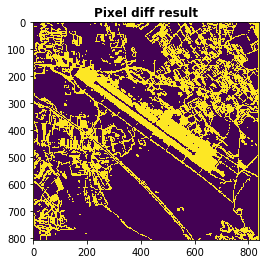

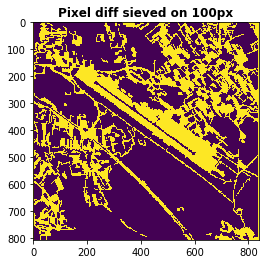

In [2]:
first_src_filepath = ''
second_src_filepath = ''

import pprint
import rasterio
import rasterio.features
import rasterio.fill
import rasterio.mask
import rasterio.plot
import rasterio.warp
import numpy

def grayscale(dataset):
    array = numpy.array((numpy.array(dataset.read(1)), numpy.array(dataset.read(2)), numpy.array(dataset.read(3)))).T
    return rgb2gray(array)

def rgb2gray(rgb):
    return numpy.array(numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), dtype='int32')

def diff(first, second, src):
    mask = first != second
    shapes = rasterio.features.shapes(second, mask=mask)
    result = rasterio.mask.mask(src, shapes=shapes, pad=True)
    return result
    

def write_to_file(file_name, mask, src_profile):
    profile = rasterio.profiles.Profile(**src_profile)
    profile.update({
        'dtype': 'int16',
        'count': 1
    })
    with rasterio.open(file_name, 'w', **profile) as dst:
                dst.write(mask.astype(rasterio.int16), 1)
        
with rasterio.Env():
    with rasterio.open(first_src_filepath) as src:
        with rasterio.open(second_src_filepath) as second_src:
            
            # extract color bands
            src_red = numpy.array(src.read(1))
            second_src_red = numpy.array(second_src.read(1))
            src_green = numpy.array(src.read(2))
            second_src_green = numpy.array(second_src.read(2))
            src_blue = numpy.array(src.read(3))
            second_src_blue = numpy.array(second_src.read(3))
            
            # create mask for each color
            red_mask = src_red != second_src_red
            green_mask = src_green != second_src_green
            blue_mask = src_blue != second_src_blue
            
            # combine color masks into one
            mask = (red_mask | green_mask | blue_mask)
            
            # convert mask into int16
            mask = numpy.array(mask, dtype='int16')
            int16_max_value = rasterio.dtypes.dtype_ranges['int16'][1]
            mask = mask * int16_max_value
            
            # pixel diff visualization
            rasterio.plot.show(mask, title='Pixel diff result')
                        
            
            sieved_mask = rasterio.features.sieve(mask, size=100)
            rasterio.plot.show(sieved_mask, title='Pixel diff sieved on 100px')            
            
            # writing sieving examples to files
            write_to_file('sieved_100.tif', rasterio.features.sieve(mask, size=100), second_src.profile)
            write_to_file('sieved_200.tif', rasterio.features.sieve(mask, size=200), second_src.profile)
            write_to_file('sieved_300.tif', rasterio.features.sieve(mask, size=300), second_src.profile)
            write_to_file('sieved_400.tif', rasterio.features.sieve(mask, size=400), second_src.profile)
            write_to_file('sieved_500.tif', rasterio.features.sieve(mask, size=500), second_src.profile)
            write_to_file('sieved_600.tif', rasterio.features.sieve(mask, size=600), second_src.profile)
            
        
        
        